# Evidence Maximisation

Let's suppose that we have numerous parameters. Sometimes the number is too large to marginalise over all of them. In this case we can use evidence maximisation to find singular values for some that maximise the evidence. This is a very simple example of how to do this.

The basic strategy is to use Expectation Maximisation, where the expectation we're maximising is the evidence,

$$Z(\theta) = \int d\theta' P(\theta'|\theta) P(D|\theta')$$

where $\theta$ are the parameters we want to maximise over, and $\theta'$ are the parameters we want to marginalise over. We can do this by iteratively computing a robust MC approximation to the evidence, and then maximising it with respect to $\theta$.

## E-step

In this step we use Nested Sampling to get the samples and weights.

$$\text{Nested Samplng} \rightarrow \{(u_i, w_i): i=1..N\}$$

where $u_i$ are the sample points and $w_i$ are the weights during shrinkage.

The evidence is then,

$$Z(\theta) = \sum_i L(u_i) w_i$$

where $L(u_i)$ is the likelihood at the sample point $u_i$. Therefore, the weights represent the prior density of the sample. 

## M-step

Now, since we take the prior to be a transform from unit prior the $w_i$ are actually independent of $\theta$. Therefore, evidence maximisation, is equivalent to maximising the likelihoods at the sample points, with respect to $\theta$, with the corresponding weights.

In this step, we take an unbiased estimator of the gradient of the evidence with respect to the parameters $\theta$, and then use a gradient ascent algorithm to maximise the evidence.

In [1]:

# for Gaussian processes 64bit is important
from jax.config import config

config.update("jax_enable_x64", True)

try:
    import haiku as hk
except ImportError:
    print("You must `pip install dm-haiku` first.")
    raise

import tensorflow_probability.substrates.jax as tfp

from jax.scipy.linalg import solve_triangular
from jax import random
from jax import numpy as jnp
import pylab as plt
import numpy as np
from jaxns.experimental import EvidenceMaximisation
from jaxns import Prior, Model

tfpd = tfp.distributions
tfpk = tfp.math.psd_kernels


/tmp/ipykernel_17589/1886966611.py:2: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config
INFO[2024-01-31 21:23:57,648]: Unable to initialize backend 'cuda': 
INFO[2024-01-31 21:23:57,649]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2024-01-31 21:23:57,650]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2024-01-31 21:23:57,650]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# Generate data

We'll use the Gaussian proccesses with outliers marginalisation.

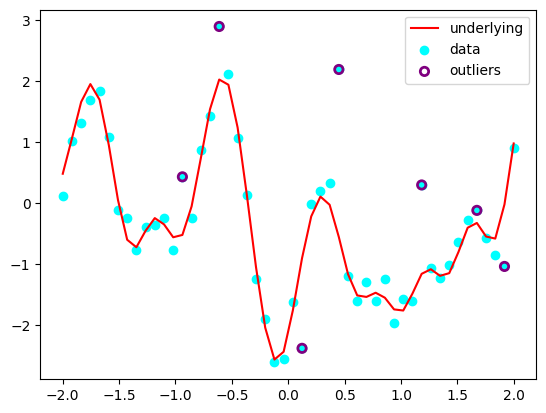

In [2]:
N = 50
num_outliers = int(0.15 * N)
np.random.seed(42)
X = jnp.linspace(-2., 2., N)[:, None]
true_sigma, true_l, true_uncert = 1., 0.2, 0.2
data_mu = jnp.zeros((N,))
prior_cov = tfpk.ExponentiatedQuadratic(amplitude=true_sigma, length_scale=true_l).matrix(X, X) + 1e-13 * jnp.eye(N)

Y = jnp.linalg.cholesky(prior_cov) @ random.normal(random.PRNGKey(42), shape=(N,)) + data_mu
Y_obs = Y + true_uncert * random.normal(random.PRNGKey(1), shape=(N,))
outliers_mask = jnp.where(jnp.isin(jnp.arange(N), np.random.choice(N, num_outliers, replace=False)), jnp.asarray(True),
                          jnp.asarray(False))
Y_obs = jnp.where(outliers_mask,
                  random.laplace(random.PRNGKey(1), shape=(N,)),
                  Y_obs)
plt.plot(X[:, 0], Y, c='red', label='underlying')
plt.scatter(X[:, 0], Y_obs, c='cyan', label='data')
plt.scatter(X[outliers_mask, 0], Y_obs[outliers_mask], label='outliers', facecolors='none', edgecolors='purple', lw=2)
plt.legend()
plt.show()


# Define the model with parameters
It is a simple model to start using parameters in the prior. You call `prior.singular()` before yielding it and you're good to go.

To use a parameter generally anywhere within your model you simply call `hk.get_parameter(...)`. 

Once you are using parameters in your model you must wrap your model in a `ParametrisedModel` to ensure that the parameters are correctly initialised and updated. Almost surely the only reason you'd do this is to use Evidence Maximisation, but it's possible you might want to use parameters in your model for other reasons, if you wanted to set parameters.

```python
model = ParametrisedModel(base_model=Model(prior_model=prior_model, log_likelihood=log_likelihood))
```

In [3]:

kernel = tfpk.ExponentiatedQuadratic


def log_normal(x, mean, cov):
    L = jnp.linalg.cholesky(cov)
    # U, S, Vh = jnp.linalg.svd(cov)
    log_det = jnp.sum(jnp.log(jnp.diag(L)))  # jnp.sum(jnp.log(S))#
    dx = x - mean
    dx = solve_triangular(L, dx, lower=True)
    # U S Vh V 1/S Uh
    # pinv = (Vh.T.conj() * jnp.where(S!=0., jnp.reciprocal(S), 0.)) @ U.T.conj()
    maha = dx @ dx  # dx @ pinv @ dx#solve_triangular(L, dx, lower=True)
    log_likelihood = -0.5 * x.size * jnp.log(2. * jnp.pi) - log_det - 0.5 * maha
    return log_likelihood


def log_likelihood(uncert, l, sigma):
    """
    P(Y|sigma, half_width) = N[Y, f, K]
    Args:
        sigma:
        l:

    Returns:

    """
    K = kernel(amplitude=sigma, length_scale=l).matrix(X, X)
    data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
    mu = jnp.zeros_like(Y_obs)
    return log_normal(Y_obs, mu, K + data_cov)


def prior_model():
    # Throw in a heirarchical prior for the length scale upper bound to show that we can do that.
    upper_l = yield Prior(tfpd.Uniform(0., 1.), name='upper_l')
    l = yield Prior(tfpd.Uniform(0., upper_l), name='l').parametrised()
    uncert = yield Prior(tfpd.Uniform(0., 2.), name='uncert')
    sigma = yield Prior(tfpd.Uniform(0., 2.), name='sigma')
    return uncert, l, sigma


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)
model.sanity_check(key=random.PRNGKey(0), S=100)

INFO[2024-01-31 21:24:00,070]: Sanity check...
INFO[2024-01-31 21:24:00,459]: Sanity check passed


Convergence achieved at step 1.:  10%|█         | 1/10 [00:13<02:01, 13.50s/it]                                                                                                                      


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 51196
samples: 1170
phantom samples: 0
likelihood evals / sample: 43.8
phantom fraction (%): 0.0%
--------
logZ=-69.84 +- 0.2
H=-3.49
ESS=199
--------
l: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
l: 0.213 +- 0.049 | 0.16 / 0.211 / 0.284 | 0.178 | 0.184
--------
sigma: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sigma: 1.33 +- 0.27 | 1.02 / 1.34 / 1.7 | 1.18 | 1.18
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.63 +- 0.096 | 0.518 / 0.629 / 0.755 | 0.567 | 0.57
--------
upper_l: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
upper_l: 0.378 +- 0.088 | 0.283 / 0.374 / 0.504 | 0.316 | 0.327
--------


/home/albert/git/jaxns/jaxns/plotting.py:47: RuntimeWarning: divide by zero encountered in divide
  efficiency = 1. / num_likelihood_evaluations_per_sample


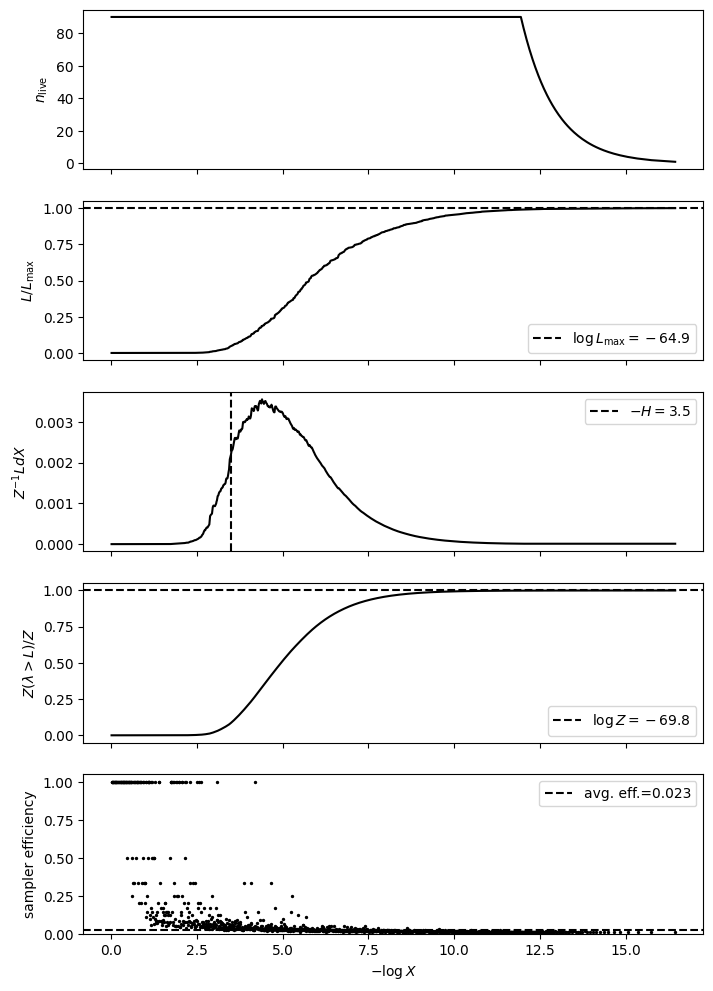

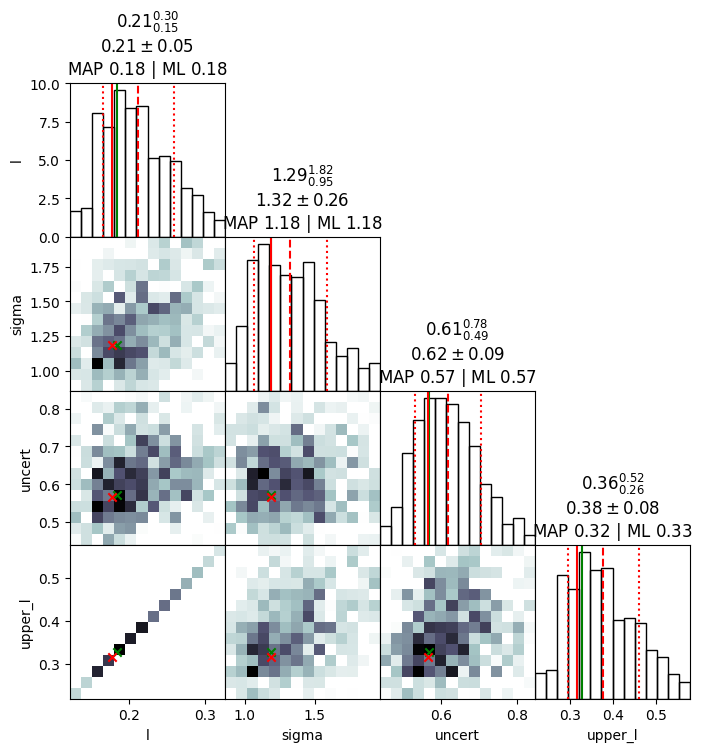

In [4]:
from jaxns import summary, plot_diagnostics, plot_cornerplot

results, params = EvidenceMaximisation(
    model=model,
    ns_kwargs=dict(max_samples=1e6)
).train(10)

summary(results, with_parametrised=True)
plot_diagnostics(results)
plot_cornerplot(results, with_parametrised=True)